This is the analysis for the ConvX (a Udacity Capstone Project). Before starting, be sure to follow the instructions in the README for the project on github (https://github.com/justiniann/ConvX).

This code was originally run on a personal desktop computer. The specs were...

CPU: Intel i5 6600K, 
GPU: Nvidia 1060 GTX, 
RAM: 16GB

I highly recommend that anyone attempting to run this code on the full dataset use hardware that is comparable or better.

First, we need to load our base model. We will also define a few variables that we will need later.

In [1]:
import os
import random
from keras.applications import ResNet50
from keras import optimizers
from keras import metrics
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.callbacks import History
from sklearn.metrics import accuracy_score, fbeta_score, confusion_matrix
import matplotlib.pyplot as plt
from convx_utils import *

# This is our base model. We will use the weights and structure already known to be successful in other domains and
#   adjust it to fit our current problem
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

target_image_size = (256, 256)
batch_size = 1000
transfer_learning_epochs = 2000
fine_tuning_epochs = 10
fine_tuning_layers_to_train = 10

Using TensorFlow backend.


We'll also define some paths that we will need later for saving various results as we run through our analysis

In [2]:
# The following are directories used for reading/saving data
RES_PATH = "..{0}..{0}resources{0}".format(os.path.sep)
IMG_PATH = "..{0}..{0}images{0}".format(os.path.sep)
BOTTLENECK_PATH = "..{0}..{0}bottleneck{0}".format(os.path.sep)
SAVE_PATH = "..{0}..{0}saved_models{0}".format(os.path.sep)
TRAIN_PATH = os.path.join(IMG_PATH, "train")
VAL_PATH = os.path.join(IMG_PATH, "validation")
TEST_PATH = os.path.join(IMG_PATH, "test")

model_name = "convx_model"  # The directory all data will be saved in will be named whatever this value is.
models_save_directory = os.path.join(SAVE_PATH, model_name)
build_dir_path(models_save_directory)  # build the directory structure we need for saving results

We haven't included the top layer because we are going to build and train the top layer ourselves. This is known as transfer learning, and it is the first major step in training our model.

Before starting that, however, we need to get a few variables we are going to need durring processing

In [3]:
def count_files(root_dir):
    return sum([len(files) for r, d, files in os.walk(root_dir)])

def get_iterations_per_epoch(total_images, batch_size):
    return np.ceil(total_images / batch_size)

healthy_train_images = count_files(os.path.join(TRAIN_PATH, "healthy"))
unhealthy_train_images = count_files(os.path.join(TRAIN_PATH, "unhealthy"))
healthy_validation_images = count_files(os.path.join(VAL_PATH, "healthy"))
unhealthy_validation_images = count_files(os.path.join(VAL_PATH, "unhealthy"))

num_training_steps = get_iterations_per_epoch((healthy_train_images + unhealthy_train_images), batch_size)
num_validation_steps = get_iterations_per_epoch((healthy_validation_images + unhealthy_validation_images), batch_size)

For efficiency, we are going to get and save the bottleneck features for this model before we start with the transfer learning. By obtaining and saving these once, we can avoid having to run every image through the entire network durring every epoch. 

In [4]:
bottleneck_file_path = os.path.join(BOTTLENECK_PATH, model_name)
train_bottleneck_file = os.path.join(bottleneck_file_path, "train.npy")
validation_bottleneck_file = os.path.join(bottleneck_file_path, "validation.npy")
    
# Extract bottleneck features if they have not been already
if not os.path.exists(bottleneck_file_path):
    data_generator = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=90,
        width_shift_range=0.2, height_shift_range=0.2,
        horizontal_flip=True, vertical_flip=True
    )

    train_generator = data_generator.flow_from_directory(
        TRAIN_PATH,
        target_size=target_image_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    
    build_dir_path(bottleneck_file_path)
    bottleneck_features_train = base_model.predict_generator(train_generator, num_training_steps)
    np.save(open(train_bottleneck_file, 'wb'), bottleneck_features_train)
    
    validation_path_generator = data_generator.flow_from_directory(
        VAL_PATH,
        target_size=target_image_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    
    bottleneck_features_validation = base_model.predict_generator(validation_path_generator, num_validation_steps)
    np.save(open(validation_bottleneck_file, 'wb'), bottleneck_features_validation)

With the bottleneck features established, we can start transfer learning.

In [5]:
def build_fully_connected_top_layer(connecting_shape):
    top_layers = Sequential()
    top_layers.add(Flatten(input_shape=connecting_shape))
    top_layers.add(Dense(256, activation='tanh'))
    top_layers.add(Dropout(0.2))
    top_layers.add(Dense(1, activation='sigmoid'))
    return top_layers

# load training data
train_data = np.load(open(train_bottleneck_file, 'rb'))
input_shape = train_data.shape[1:]
train_labels = np.array(([0] * healthy_train_images) + ([1] * unhealthy_train_images))

# load validation data
validation_data = np.load(open(validation_bottleneck_file, 'rb'))
validation_labels = np.array([0] * healthy_validation_images + [1] * unhealthy_validation_images)

top_layer = build_fully_connected_top_layer(input_shape)

top_layer.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=0.005),
                  metrics=[metrics.binary_accuracy])

transfer_history = top_layer.fit(train_data, train_labels,
              epochs=transfer_learning_epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              shuffle=True,
              verbose=1)

top_layers_weights_path = os.path.join(models_save_directory, "transfer_learning_weights.h5")
top_layer.save_weights(top_layers_weights_path)

Train on 80725 samples, validate on 8970 samples
Epoch 1/2000
80725/80725 [==============================] - 4s - loss: 7.3615 - binary_accuracy: 0.5372 - val_loss: 7.5200 - val_binary_accuracy: 0.5334
Epoch 2/2000
80725/80725 [==============================] - 4s - loss: 7.4436 - binary_accuracy: 0.5382 - val_loss: 7.5200 - val_binary_accuracy: 0.5334
Epoch 3/2000
80725/80725 [==============================] - 4s - loss: 7.4436 - binary_accuracy: 0.5382 - val_loss: 7.5200 - val_binary_accuracy: 0.5334
Epoch 4/2000
80725/80725 [==============================] - 4s - loss: 7.4436 - binary_accuracy: 0.5382 - val_loss: 7.5200 - val_binary_accuracy: 0.5334
Epoch 5/2000
80725/80725 [==============================] - 4s - loss: 7.4436 - binary_accuracy: 0.5382 - val_loss: 7.5200 - val_binary_accuracy: 0.5334
Epoch 6/2000
80725/80725 [==============================] - 4s - loss: 7.4436 - binary_accuracy: 0.5382 - val_loss: 7.5200 - val_binary_accuracy: 0.5334
Epoch 7/2000
80725/80725 [=======

80725/80725 [==============================] - 4s - loss: 0.7401 - binary_accuracy: 0.5002 - val_loss: 0.7881 - val_binary_accuracy: 0.5334
Epoch 54/2000
80725/80725 [==============================] - 4s - loss: 0.7363 - binary_accuracy: 0.5058 - val_loss: 0.8400 - val_binary_accuracy: 0.5334
Epoch 55/2000
80725/80725 [==============================] - 4s - loss: 0.7374 - binary_accuracy: 0.5082 - val_loss: 0.6956 - val_binary_accuracy: 0.5334
Epoch 56/2000
80725/80725 [==============================] - 4s - loss: 0.7408 - binary_accuracy: 0.5033 - val_loss: 0.7106 - val_binary_accuracy: 0.5334
Epoch 57/2000
80725/80725 [==============================] - 4s - loss: 0.7405 - binary_accuracy: 0.4982 - val_loss: 0.7234 - val_binary_accuracy: 0.4666
Epoch 58/2000
80725/80725 [==============================] - 4s - loss: 0.7398 - binary_accuracy: 0.5032 - val_loss: 0.7359 - val_binary_accuracy: 0.5334
Epoch 59/2000
80725/80725 [==============================] - 4s - loss: 0.7402 - binary_ac

80725/80725 [==============================] - 4s - loss: 0.7406 - binary_accuracy: 0.5018 - val_loss: 0.7076 - val_binary_accuracy: 0.5334
Epoch 107/2000
80725/80725 [==============================] - 4s - loss: 0.7431 - binary_accuracy: 0.4962 - val_loss: 0.7439 - val_binary_accuracy: 0.4666
Epoch 108/2000
80725/80725 [==============================] - 4s - loss: 0.7374 - binary_accuracy: 0.5009 - val_loss: 0.8282 - val_binary_accuracy: 0.5334
Epoch 109/2000
80725/80725 [==============================] - 4s - loss: 0.7431 - binary_accuracy: 0.4990 - val_loss: 0.7481 - val_binary_accuracy: 0.4666
Epoch 110/2000
80725/80725 [==============================] - 4s - loss: 0.7441 - binary_accuracy: 0.4947 - val_loss: 0.7145 - val_binary_accuracy: 0.5334
Epoch 111/2000
80725/80725 [==============================] - 4s - loss: 0.7404 - binary_accuracy: 0.5002 - val_loss: 0.7611 - val_binary_accuracy: 0.4666
Epoch 112/2000
80725/80725 [==============================] - 4s - loss: 0.7384 - bin

80725/80725 [==============================] - 4s - loss: 0.7412 - binary_accuracy: 0.4988 - val_loss: 0.7167 - val_binary_accuracy: 0.5334
Epoch 159/2000
80725/80725 [==============================] - 4s - loss: 0.7368 - binary_accuracy: 0.5020 - val_loss: 0.7054 - val_binary_accuracy: 0.4666
Epoch 160/2000
80725/80725 [==============================] - 4s - loss: 0.7427 - binary_accuracy: 0.5010 - val_loss: 0.7009 - val_binary_accuracy: 0.5334
Epoch 161/2000
80725/80725 [==============================] - 4s - loss: 0.7403 - binary_accuracy: 0.5002 - val_loss: 0.7393 - val_binary_accuracy: 0.4666
Epoch 162/2000
80725/80725 [==============================] - 4s - loss: 0.7434 - binary_accuracy: 0.4993 - val_loss: 0.7285 - val_binary_accuracy: 0.5334
Epoch 163/2000
80725/80725 [==============================] - 4s - loss: 0.7379 - binary_accuracy: 0.5037 - val_loss: 0.7385 - val_binary_accuracy: 0.5334
Epoch 164/2000
80725/80725 [==============================] - 4s - loss: 0.7395 - bin

80725/80725 [==============================] - 4s - loss: 0.7373 - binary_accuracy: 0.5037 - val_loss: 0.8261 - val_binary_accuracy: 0.5334
Epoch 211/2000
80725/80725 [==============================] - 4s - loss: 0.7424 - binary_accuracy: 0.4992 - val_loss: 0.7152 - val_binary_accuracy: 0.4666
Epoch 212/2000
80725/80725 [==============================] - 4s - loss: 0.7385 - binary_accuracy: 0.5017 - val_loss: 0.6909 - val_binary_accuracy: 0.5334
Epoch 213/2000
80725/80725 [==============================] - 4s - loss: 0.7438 - binary_accuracy: 0.4991 - val_loss: 0.7050 - val_binary_accuracy: 0.4666
Epoch 214/2000
80725/80725 [==============================] - 4s - loss: 0.7425 - binary_accuracy: 0.4967 - val_loss: 0.7207 - val_binary_accuracy: 0.5334
Epoch 215/2000
80725/80725 [==============================] - 4s - loss: 0.7394 - binary_accuracy: 0.5010 - val_loss: 0.7244 - val_binary_accuracy: 0.5334
Epoch 216/2000
80725/80725 [==============================] - 4s - loss: 0.7397 - bin

80725/80725 [==============================] - 4s - loss: 0.7418 - binary_accuracy: 0.4997 - val_loss: 0.6974 - val_binary_accuracy: 0.5334
Epoch 263/2000
80725/80725 [==============================] - 4s - loss: 0.7408 - binary_accuracy: 0.5013 - val_loss: 0.7241 - val_binary_accuracy: 0.5334
Epoch 264/2000
80725/80725 [==============================] - 4s - loss: 0.7407 - binary_accuracy: 0.4983 - val_loss: 0.7493 - val_binary_accuracy: 0.4666
Epoch 265/2000
80725/80725 [==============================] - 4s - loss: 0.7412 - binary_accuracy: 0.4990 - val_loss: 0.7598 - val_binary_accuracy: 0.5334
Epoch 266/2000
80725/80725 [==============================] - 4s - loss: 0.7434 - binary_accuracy: 0.4975 - val_loss: 0.7179 - val_binary_accuracy: 0.4666
Epoch 267/2000
80725/80725 [==============================] - 4s - loss: 0.7380 - binary_accuracy: 0.5004 - val_loss: 0.7699 - val_binary_accuracy: 0.5334
Epoch 268/2000
80725/80725 [==============================] - 4s - loss: 0.7415 - bin

80725/80725 [==============================] - 4s - loss: 0.7433 - binary_accuracy: 0.4985 - val_loss: 0.7582 - val_binary_accuracy: 0.4666
Epoch 315/2000
80725/80725 [==============================] - 4s - loss: 0.7401 - binary_accuracy: 0.5007 - val_loss: 0.6987 - val_binary_accuracy: 0.5334
Epoch 316/2000
80725/80725 [==============================] - 4s - loss: 0.7402 - binary_accuracy: 0.5029 - val_loss: 0.7617 - val_binary_accuracy: 0.5334
Epoch 317/2000
80725/80725 [==============================] - 4s - loss: 0.7392 - binary_accuracy: 0.5000 - val_loss: 0.6936 - val_binary_accuracy: 0.4666
Epoch 318/2000
80725/80725 [==============================] - 4s - loss: 0.7434 - binary_accuracy: 0.4975 - val_loss: 0.7378 - val_binary_accuracy: 0.5334
Epoch 319/2000
80725/80725 [==============================] - 4s - loss: 0.7376 - binary_accuracy: 0.5033 - val_loss: 0.6990 - val_binary_accuracy: 0.5334
Epoch 320/2000
80725/80725 [==============================] - 4s - loss: 0.7418 - bin

80725/80725 [==============================] - 4s - loss: 0.7379 - binary_accuracy: 0.5035 - val_loss: 0.6958 - val_binary_accuracy: 0.4666
Epoch 367/2000
80725/80725 [==============================] - 4s - loss: 0.7412 - binary_accuracy: 0.5010 - val_loss: 0.7256 - val_binary_accuracy: 0.4666
Epoch 368/2000
80725/80725 [==============================] - 4s - loss: 0.7375 - binary_accuracy: 0.5012 - val_loss: 0.7317 - val_binary_accuracy: 0.5334
Epoch 369/2000
80725/80725 [==============================] - 4s - loss: 0.7434 - binary_accuracy: 0.4957 - val_loss: 0.7515 - val_binary_accuracy: 0.4666
Epoch 370/2000
80725/80725 [==============================] - 4s - loss: 0.7420 - binary_accuracy: 0.4989 - val_loss: 0.7509 - val_binary_accuracy: 0.5334
Epoch 371/2000
80725/80725 [==============================] - 4s - loss: 0.7398 - binary_accuracy: 0.5003 - val_loss: 0.7539 - val_binary_accuracy: 0.4666
Epoch 372/2000
80725/80725 [==============================] - 4s - loss: 0.7399 - bin

80725/80725 [==============================] - 4s - loss: 0.7407 - binary_accuracy: 0.4995 - val_loss: 0.7228 - val_binary_accuracy: 0.5334
Epoch 419/2000
80725/80725 [==============================] - 4s - loss: 0.7392 - binary_accuracy: 0.5002 - val_loss: 0.7491 - val_binary_accuracy: 0.4666
Epoch 420/2000
80725/80725 [==============================] - 4s - loss: 0.7358 - binary_accuracy: 0.5067 - val_loss: 0.8129 - val_binary_accuracy: 0.5334
Epoch 421/2000
80725/80725 [==============================] - 4s - loss: 0.7424 - binary_accuracy: 0.5056 - val_loss: 0.7027 - val_binary_accuracy: 0.5334
Epoch 422/2000
80725/80725 [==============================] - 4s - loss: 0.7401 - binary_accuracy: 0.5012 - val_loss: 0.7352 - val_binary_accuracy: 0.4666
Epoch 423/2000
80725/80725 [==============================] - 4s - loss: 0.7401 - binary_accuracy: 0.4996 - val_loss: 0.7947 - val_binary_accuracy: 0.5334
Epoch 424/2000
80725/80725 [==============================] - 4s - loss: 0.7422 - bin

80725/80725 [==============================] - 4s - loss: 0.7405 - binary_accuracy: 0.4991 - val_loss: 0.7421 - val_binary_accuracy: 0.5334
Epoch 471/2000
80725/80725 [==============================] - 4s - loss: 0.7416 - binary_accuracy: 0.5027 - val_loss: 0.7565 - val_binary_accuracy: 0.5334
Epoch 472/2000
80725/80725 [==============================] - 4s - loss: 0.7383 - binary_accuracy: 0.5023 - val_loss: 0.7159 - val_binary_accuracy: 0.5334
Epoch 473/2000
80725/80725 [==============================] - 4s - loss: 0.7395 - binary_accuracy: 0.5022 - val_loss: 0.7150 - val_binary_accuracy: 0.4666
Epoch 474/2000
80725/80725 [==============================] - 4s - loss: 0.7399 - binary_accuracy: 0.4992 - val_loss: 0.7070 - val_binary_accuracy: 0.5334
Epoch 475/2000
80725/80725 [==============================] - 4s - loss: 0.7391 - binary_accuracy: 0.5016 - val_loss: 0.7053 - val_binary_accuracy: 0.4666
Epoch 476/2000
80725/80725 [==============================] - 3s - loss: 0.7375 - bin

80725/80725 [==============================] - 4s - loss: 0.7423 - binary_accuracy: 0.5001 - val_loss: 0.7174 - val_binary_accuracy: 0.4666
Epoch 523/2000
80725/80725 [==============================] - 4s - loss: 0.7430 - binary_accuracy: 0.4982 - val_loss: 0.7389 - val_binary_accuracy: 0.4666
Epoch 524/2000
80725/80725 [==============================] - 4s - loss: 0.7402 - binary_accuracy: 0.4976 - val_loss: 0.7878 - val_binary_accuracy: 0.5334
Epoch 525/2000
80725/80725 [==============================] - 4s - loss: 0.7397 - binary_accuracy: 0.5037 - val_loss: 0.7344 - val_binary_accuracy: 0.4666
Epoch 526/2000
80725/80725 [==============================] - 4s - loss: 0.7404 - binary_accuracy: 0.4992 - val_loss: 0.7319 - val_binary_accuracy: 0.5334
Epoch 527/2000
80725/80725 [==============================] - 4s - loss: 0.7382 - binary_accuracy: 0.5025 - val_loss: 0.7719 - val_binary_accuracy: 0.4666
Epoch 528/2000
80725/80725 [==============================] - 4s - loss: 0.7436 - bin

80725/80725 [==============================] - 4s - loss: 0.7401 - binary_accuracy: 0.5037 - val_loss: 0.7665 - val_binary_accuracy: 0.4666
Epoch 575/2000
80725/80725 [==============================] - 4s - loss: 0.7406 - binary_accuracy: 0.5011 - val_loss: 0.7228 - val_binary_accuracy: 0.4666
Epoch 576/2000
80725/80725 [==============================] - 4s - loss: 0.7374 - binary_accuracy: 0.5038 - val_loss: 0.7350 - val_binary_accuracy: 0.4666
Epoch 577/2000
80725/80725 [==============================] - 4s - loss: 0.7434 - binary_accuracy: 0.4955 - val_loss: 0.7476 - val_binary_accuracy: 0.5334
Epoch 578/2000
80725/80725 [==============================] - 4s - loss: 0.7372 - binary_accuracy: 0.5031 - val_loss: 0.7593 - val_binary_accuracy: 0.4666
Epoch 579/2000
80725/80725 [==============================] - 4s - loss: 0.7436 - binary_accuracy: 0.5007 - val_loss: 0.7091 - val_binary_accuracy: 0.5334
Epoch 580/2000
80725/80725 [==============================] - 4s - loss: 0.7419 - bin

80725/80725 [==============================] - 3s - loss: 0.7375 - binary_accuracy: 0.5023 - val_loss: 0.7527 - val_binary_accuracy: 0.5334
Epoch 627/2000
80725/80725 [==============================] - 3s - loss: 0.7406 - binary_accuracy: 0.5014 - val_loss: 0.6969 - val_binary_accuracy: 0.4666
Epoch 628/2000
80725/80725 [==============================] - 4s - loss: 0.7393 - binary_accuracy: 0.5048 - val_loss: 0.7285 - val_binary_accuracy: 0.4666
Epoch 629/2000
80725/80725 [==============================] - 4s - loss: 0.7418 - binary_accuracy: 0.4976 - val_loss: 0.7809 - val_binary_accuracy: 0.5334
Epoch 630/2000
80725/80725 [==============================] - 4s - loss: 0.7416 - binary_accuracy: 0.4979 - val_loss: 0.7349 - val_binary_accuracy: 0.4666
Epoch 631/2000
80725/80725 [==============================] - 4s - loss: 0.7387 - binary_accuracy: 0.5041 - val_loss: 0.7160 - val_binary_accuracy: 0.4666
Epoch 632/2000
80725/80725 [==============================] - 4s - loss: 0.7389 - bin

80725/80725 [==============================] - 4s - loss: 0.7380 - binary_accuracy: 0.5038 - val_loss: 0.7928 - val_binary_accuracy: 0.5334
Epoch 679/2000
80725/80725 [==============================] - 4s - loss: 0.7409 - binary_accuracy: 0.4996 - val_loss: 0.7258 - val_binary_accuracy: 0.4666
Epoch 680/2000
80725/80725 [==============================] - 4s - loss: 0.7406 - binary_accuracy: 0.5014 - val_loss: 0.7352 - val_binary_accuracy: 0.5334
Epoch 681/2000
80725/80725 [==============================] - 4s - loss: 0.7417 - binary_accuracy: 0.4989 - val_loss: 0.7234 - val_binary_accuracy: 0.4666
Epoch 682/2000
80725/80725 [==============================] - 4s - loss: 0.7388 - binary_accuracy: 0.4989 - val_loss: 0.7089 - val_binary_accuracy: 0.5334
Epoch 683/2000
80725/80725 [==============================] - 4s - loss: 0.7398 - binary_accuracy: 0.5021 - val_loss: 0.7591 - val_binary_accuracy: 0.4666
Epoch 684/2000
80725/80725 [==============================] - 4s - loss: 0.7378 - bin

80725/80725 [==============================] - 4s - loss: 0.7436 - binary_accuracy: 0.4996 - val_loss: 0.7210 - val_binary_accuracy: 0.5334
Epoch 731/2000
80725/80725 [==============================] - 4s - loss: 0.7400 - binary_accuracy: 0.4996 - val_loss: 0.7419 - val_binary_accuracy: 0.4666
Epoch 732/2000
80725/80725 [==============================] - 4s - loss: 0.7393 - binary_accuracy: 0.5016 - val_loss: 0.7244 - val_binary_accuracy: 0.5334
Epoch 733/2000
80725/80725 [==============================] - 4s - loss: 0.7412 - binary_accuracy: 0.5009 - val_loss: 0.7302 - val_binary_accuracy: 0.4666
Epoch 734/2000
80725/80725 [==============================] - 4s - loss: 0.7407 - binary_accuracy: 0.5007 - val_loss: 0.7179 - val_binary_accuracy: 0.4666
Epoch 735/2000
80725/80725 [==============================] - 4s - loss: 0.7365 - binary_accuracy: 0.5029 - val_loss: 0.7501 - val_binary_accuracy: 0.4666
Epoch 736/2000
80725/80725 [==============================] - 4s - loss: 0.7412 - bin

80725/80725 [==============================] - 4s - loss: 0.7439 - binary_accuracy: 0.5016 - val_loss: 0.7660 - val_binary_accuracy: 0.4666
Epoch 783/2000
80725/80725 [==============================] - 4s - loss: 0.7386 - binary_accuracy: 0.5008 - val_loss: 0.7834 - val_binary_accuracy: 0.5334
Epoch 784/2000
80725/80725 [==============================] - 4s - loss: 0.7425 - binary_accuracy: 0.4988 - val_loss: 0.7705 - val_binary_accuracy: 0.4666
Epoch 785/2000
80725/80725 [==============================] - 4s - loss: 0.7392 - binary_accuracy: 0.5056 - val_loss: 0.7177 - val_binary_accuracy: 0.5334
Epoch 786/2000
80725/80725 [==============================] - 4s - loss: 0.7388 - binary_accuracy: 0.5013 - val_loss: 0.7408 - val_binary_accuracy: 0.4666
Epoch 787/2000
80725/80725 [==============================] - 4s - loss: 0.7379 - binary_accuracy: 0.5023 - val_loss: 0.6948 - val_binary_accuracy: 0.4666
Epoch 788/2000
80725/80725 [==============================] - 4s - loss: 0.7408 - bin

80725/80725 [==============================] - 4s - loss: 0.7399 - binary_accuracy: 0.5019 - val_loss: 0.7126 - val_binary_accuracy: 0.5334
Epoch 835/2000
80725/80725 [==============================] - 4s - loss: 0.7360 - binary_accuracy: 0.5045 - val_loss: 0.7624 - val_binary_accuracy: 0.4666
Epoch 836/2000
80725/80725 [==============================] - 4s - loss: 0.7413 - binary_accuracy: 0.5025 - val_loss: 0.7380 - val_binary_accuracy: 0.4666
Epoch 837/2000
80725/80725 [==============================] - 3s - loss: 0.7410 - binary_accuracy: 0.4996 - val_loss: 0.7648 - val_binary_accuracy: 0.4666
Epoch 838/2000
80725/80725 [==============================] - 3s - loss: 0.7407 - binary_accuracy: 0.5000 - val_loss: 0.8026 - val_binary_accuracy: 0.5334
Epoch 839/2000
80725/80725 [==============================] - 3s - loss: 0.7383 - binary_accuracy: 0.5033 - val_loss: 0.7527 - val_binary_accuracy: 0.4666
Epoch 840/2000
80725/80725 [==============================] - 3s - loss: 0.7392 - bin

80725/80725 [==============================] - 4s - loss: 0.7380 - binary_accuracy: 0.5035 - val_loss: 0.7142 - val_binary_accuracy: 0.4666
Epoch 887/2000
80725/80725 [==============================] - 4s - loss: 0.7383 - binary_accuracy: 0.5015 - val_loss: 0.6964 - val_binary_accuracy: 0.4666
Epoch 888/2000
80725/80725 [==============================] - 4s - loss: 0.7402 - binary_accuracy: 0.5047 - val_loss: 0.7293 - val_binary_accuracy: 0.4666
Epoch 889/2000
80725/80725 [==============================] - 4s - loss: 0.7409 - binary_accuracy: 0.5037 - val_loss: 0.6980 - val_binary_accuracy: 0.4666
Epoch 890/2000
80725/80725 [==============================] - 4s - loss: 0.7391 - binary_accuracy: 0.5038 - val_loss: 0.7038 - val_binary_accuracy: 0.4666
Epoch 891/2000
80725/80725 [==============================] - 4s - loss: 0.7394 - binary_accuracy: 0.5001 - val_loss: 0.7385 - val_binary_accuracy: 0.5334
Epoch 892/2000
80725/80725 [==============================] - 4s - loss: 0.7416 - bin

80725/80725 [==============================] - 3s - loss: 0.7364 - binary_accuracy: 0.5059 - val_loss: 0.6978 - val_binary_accuracy: 0.5334
Epoch 939/2000
80725/80725 [==============================] - 4s - loss: 0.7392 - binary_accuracy: 0.5027 - val_loss: 0.7365 - val_binary_accuracy: 0.5334
Epoch 940/2000
80725/80725 [==============================] - 4s - loss: 0.7406 - binary_accuracy: 0.5000 - val_loss: 0.7792 - val_binary_accuracy: 0.4666
Epoch 941/2000
80725/80725 [==============================] - 4s - loss: 0.7378 - binary_accuracy: 0.5003 - val_loss: 0.7786 - val_binary_accuracy: 0.5334
Epoch 942/2000
80725/80725 [==============================] - 4s - loss: 0.7439 - binary_accuracy: 0.5016 - val_loss: 0.7391 - val_binary_accuracy: 0.4666
Epoch 943/2000
80725/80725 [==============================] - 4s - loss: 0.7391 - binary_accuracy: 0.4989 - val_loss: 0.7614 - val_binary_accuracy: 0.5334
Epoch 944/2000
80725/80725 [==============================] - 4s - loss: 0.7407 - bin

80725/80725 [==============================] - 4s - loss: 0.7423 - binary_accuracy: 0.4986 - val_loss: 0.7121 - val_binary_accuracy: 0.5334
Epoch 991/2000
80725/80725 [==============================] - 4s - loss: 0.7396 - binary_accuracy: 0.4998 - val_loss: 0.7521 - val_binary_accuracy: 0.4666
Epoch 992/2000
80725/80725 [==============================] - 4s - loss: 0.7406 - binary_accuracy: 0.5013 - val_loss: 0.7452 - val_binary_accuracy: 0.5334
Epoch 993/2000
80725/80725 [==============================] - 4s - loss: 0.7401 - binary_accuracy: 0.5014 - val_loss: 0.7175 - val_binary_accuracy: 0.4666
Epoch 994/2000
80725/80725 [==============================] - 4s - loss: 0.7392 - binary_accuracy: 0.5044 - val_loss: 0.7142 - val_binary_accuracy: 0.4666
Epoch 995/2000
80725/80725 [==============================] - 4s - loss: 0.7375 - binary_accuracy: 0.5024 - val_loss: 0.7085 - val_binary_accuracy: 0.5334
Epoch 996/2000
80725/80725 [==============================] - 4s - loss: 0.7370 - bin

80725/80725 [==============================] - 4s - loss: 0.7438 - binary_accuracy: 0.4969 - val_loss: 0.7985 - val_binary_accuracy: 0.5334
Epoch 1043/2000
80725/80725 [==============================] - 4s - loss: 0.7374 - binary_accuracy: 0.5054 - val_loss: 0.7521 - val_binary_accuracy: 0.5334
Epoch 1044/2000
80725/80725 [==============================] - 4s - loss: 0.7419 - binary_accuracy: 0.4984 - val_loss: 0.7028 - val_binary_accuracy: 0.4666
Epoch 1045/2000
80725/80725 [==============================] - 4s - loss: 0.7423 - binary_accuracy: 0.5002 - val_loss: 0.7229 - val_binary_accuracy: 0.5334
Epoch 1046/2000
80725/80725 [==============================] - 4s - loss: 0.7403 - binary_accuracy: 0.4987 - val_loss: 0.7231 - val_binary_accuracy: 0.4666
Epoch 1047/2000
80725/80725 [==============================] - 4s - loss: 0.7353 - binary_accuracy: 0.5081 - val_loss: 0.7542 - val_binary_accuracy: 0.4666
Epoch 1048/2000
80725/80725 [==============================] - 4s - loss: 0.7422

80725/80725 [==============================] - 4s - loss: 0.7364 - binary_accuracy: 0.5022 - val_loss: 0.7428 - val_binary_accuracy: 0.4666
Epoch 1095/2000
80725/80725 [==============================] - 4s - loss: 0.7396 - binary_accuracy: 0.5022 - val_loss: 0.7493 - val_binary_accuracy: 0.5334
Epoch 1096/2000
80725/80725 [==============================] - 4s - loss: 0.7396 - binary_accuracy: 0.5036 - val_loss: 0.7577 - val_binary_accuracy: 0.4666
Epoch 1097/2000
80725/80725 [==============================] - 4s - loss: 0.7419 - binary_accuracy: 0.4975 - val_loss: 0.7485 - val_binary_accuracy: 0.5334
Epoch 1098/2000
80725/80725 [==============================] - 4s - loss: 0.7415 - binary_accuracy: 0.5000 - val_loss: 0.7282 - val_binary_accuracy: 0.4666
Epoch 1099/2000
80725/80725 [==============================] - 4s - loss: 0.7383 - binary_accuracy: 0.5013 - val_loss: 0.7407 - val_binary_accuracy: 0.4666
Epoch 1100/2000
80725/80725 [==============================] - 4s - loss: 0.7405

80725/80725 [==============================] - 4s - loss: 0.7384 - binary_accuracy: 0.5061 - val_loss: 0.7381 - val_binary_accuracy: 0.4666
Epoch 1147/2000
80725/80725 [==============================] - 4s - loss: 0.7402 - binary_accuracy: 0.4998 - val_loss: 0.7939 - val_binary_accuracy: 0.5334
Epoch 1148/2000
80725/80725 [==============================] - 4s - loss: 0.7424 - binary_accuracy: 0.4981 - val_loss: 0.7416 - val_binary_accuracy: 0.4666
Epoch 1149/2000
80725/80725 [==============================] - 4s - loss: 0.7387 - binary_accuracy: 0.4997 - val_loss: 0.7498 - val_binary_accuracy: 0.5334
Epoch 1150/2000
80725/80725 [==============================] - 4s - loss: 0.7428 - binary_accuracy: 0.4993 - val_loss: 0.7324 - val_binary_accuracy: 0.4666
Epoch 1151/2000
80725/80725 [==============================] - 4s - loss: 0.7394 - binary_accuracy: 0.5014 - val_loss: 0.7157 - val_binary_accuracy: 0.5334
Epoch 1152/2000
80725/80725 [==============================] - 4s - loss: 0.7403

80725/80725 [==============================] - 4s - loss: 0.7424 - binary_accuracy: 0.4986 - val_loss: 0.7098 - val_binary_accuracy: 0.4666
Epoch 1199/2000
80725/80725 [==============================] - 4s - loss: 0.7411 - binary_accuracy: 0.5009 - val_loss: 0.7583 - val_binary_accuracy: 0.4666
Epoch 1200/2000
80725/80725 [==============================] - 4s - loss: 0.7397 - binary_accuracy: 0.4998 - val_loss: 0.7430 - val_binary_accuracy: 0.5334
Epoch 1201/2000
80725/80725 [==============================] - 4s - loss: 0.7381 - binary_accuracy: 0.5022 - val_loss: 0.6968 - val_binary_accuracy: 0.5334
Epoch 1202/2000
80725/80725 [==============================] - 4s - loss: 0.7406 - binary_accuracy: 0.5000 - val_loss: 0.7962 - val_binary_accuracy: 0.4666
Epoch 1203/2000
80725/80725 [==============================] - 4s - loss: 0.7380 - binary_accuracy: 0.5033 - val_loss: 0.6952 - val_binary_accuracy: 0.4666
Epoch 1204/2000
80725/80725 [==============================] - 4s - loss: 0.7429

80725/80725 [==============================] - 4s - loss: 0.7391 - binary_accuracy: 0.5008 - val_loss: 0.7361 - val_binary_accuracy: 0.4666
Epoch 1251/2000
80725/80725 [==============================] - 4s - loss: 0.7411 - binary_accuracy: 0.5022 - val_loss: 0.7198 - val_binary_accuracy: 0.4666
Epoch 1252/2000
80725/80725 [==============================] - 4s - loss: 0.7381 - binary_accuracy: 0.5002 - val_loss: 0.7264 - val_binary_accuracy: 0.4666
Epoch 1253/2000
80725/80725 [==============================] - 4s - loss: 0.7451 - binary_accuracy: 0.4959 - val_loss: 0.7154 - val_binary_accuracy: 0.5334
Epoch 1254/2000
80725/80725 [==============================] - 4s - loss: 0.7401 - binary_accuracy: 0.4991 - val_loss: 0.8695 - val_binary_accuracy: 0.4666
Epoch 1255/2000
80725/80725 [==============================] - 4s - loss: 0.7413 - binary_accuracy: 0.4999 - val_loss: 0.7271 - val_binary_accuracy: 0.5334
Epoch 1256/2000
80725/80725 [==============================] - 4s - loss: 0.7391

80725/80725 [==============================] - 4s - loss: 0.7378 - binary_accuracy: 0.5049 - val_loss: 0.8388 - val_binary_accuracy: 0.5334
Epoch 1303/2000
80725/80725 [==============================] - 4s - loss: 0.7405 - binary_accuracy: 0.5008 - val_loss: 0.6952 - val_binary_accuracy: 0.5334
Epoch 1304/2000
80725/80725 [==============================] - 4s - loss: 0.7428 - binary_accuracy: 0.4977 - val_loss: 0.7671 - val_binary_accuracy: 0.4666
Epoch 1305/2000
80725/80725 [==============================] - 4s - loss: 0.7416 - binary_accuracy: 0.4999 - val_loss: 0.6963 - val_binary_accuracy: 0.4666
Epoch 1306/2000
80725/80725 [==============================] - 4s - loss: 0.7409 - binary_accuracy: 0.4988 - val_loss: 0.7470 - val_binary_accuracy: 0.5334
Epoch 1307/2000
80725/80725 [==============================] - 4s - loss: 0.7425 - binary_accuracy: 0.4959 - val_loss: 0.7132 - val_binary_accuracy: 0.4666
Epoch 1308/2000
80725/80725 [==============================] - 4s - loss: 0.7416

80725/80725 [==============================] - 4s - loss: 0.7384 - binary_accuracy: 0.5020 - val_loss: 0.7148 - val_binary_accuracy: 0.5334
Epoch 1355/2000
80725/80725 [==============================] - 4s - loss: 0.7411 - binary_accuracy: 0.5000 - val_loss: 0.7404 - val_binary_accuracy: 0.4666
Epoch 1356/2000
80725/80725 [==============================] - 4s - loss: 0.7439 - binary_accuracy: 0.4967 - val_loss: 0.7436 - val_binary_accuracy: 0.5334
Epoch 1357/2000
80725/80725 [==============================] - 4s - loss: 0.7424 - binary_accuracy: 0.4973 - val_loss: 0.7095 - val_binary_accuracy: 0.4666
Epoch 1358/2000
80725/80725 [==============================] - 4s - loss: 0.7399 - binary_accuracy: 0.4995 - val_loss: 0.6972 - val_binary_accuracy: 0.5334
Epoch 1359/2000
80725/80725 [==============================] - 4s - loss: 0.7435 - binary_accuracy: 0.4977 - val_loss: 0.7535 - val_binary_accuracy: 0.4666
Epoch 1360/2000
80725/80725 [==============================] - 4s - loss: 0.7400

80725/80725 [==============================] - 4s - loss: 0.7400 - binary_accuracy: 0.5035 - val_loss: 0.7326 - val_binary_accuracy: 0.5334
Epoch 1407/2000
80725/80725 [==============================] - 4s - loss: 0.7385 - binary_accuracy: 0.5039 - val_loss: 0.7096 - val_binary_accuracy: 0.4666
Epoch 1408/2000
80725/80725 [==============================] - 4s - loss: 0.7369 - binary_accuracy: 0.5040 - val_loss: 0.7232 - val_binary_accuracy: 0.4666
Epoch 1409/2000
80725/80725 [==============================] - 4s - loss: 0.7403 - binary_accuracy: 0.5011 - val_loss: 0.7293 - val_binary_accuracy: 0.5334
Epoch 1410/2000
80725/80725 [==============================] - 4s - loss: 0.7382 - binary_accuracy: 0.5058 - val_loss: 0.6972 - val_binary_accuracy: 0.5334
Epoch 1411/2000
80725/80725 [==============================] - 4s - loss: 0.7408 - binary_accuracy: 0.4981 - val_loss: 0.7528 - val_binary_accuracy: 0.4666
Epoch 1412/2000
80725/80725 [==============================] - 4s - loss: 0.7394

80725/80725 [==============================] - 4s - loss: 0.7423 - binary_accuracy: 0.4971 - val_loss: 0.7615 - val_binary_accuracy: 0.5334
Epoch 1459/2000
80725/80725 [==============================] - 4s - loss: 0.7372 - binary_accuracy: 0.5042 - val_loss: 0.7673 - val_binary_accuracy: 0.5334
Epoch 1460/2000
80725/80725 [==============================] - 4s - loss: 0.7418 - binary_accuracy: 0.5003 - val_loss: 0.7172 - val_binary_accuracy: 0.4666
Epoch 1461/2000
80725/80725 [==============================] - 4s - loss: 0.7425 - binary_accuracy: 0.4968 - val_loss: 0.7419 - val_binary_accuracy: 0.5334
Epoch 1462/2000
80725/80725 [==============================] - 4s - loss: 0.7388 - binary_accuracy: 0.5009 - val_loss: 0.7762 - val_binary_accuracy: 0.5334
Epoch 1463/2000
80725/80725 [==============================] - 4s - loss: 0.7428 - binary_accuracy: 0.5003 - val_loss: 0.7075 - val_binary_accuracy: 0.4666
Epoch 1464/2000
80725/80725 [==============================] - 4s - loss: 0.7377

80725/80725 [==============================] - 4s - loss: 0.7350 - binary_accuracy: 0.5049 - val_loss: 0.7560 - val_binary_accuracy: 0.5334
Epoch 1511/2000
80725/80725 [==============================] - 4s - loss: 0.7406 - binary_accuracy: 0.5009 - val_loss: 0.7541 - val_binary_accuracy: 0.4666
Epoch 1512/2000
80725/80725 [==============================] - 4s - loss: 0.7432 - binary_accuracy: 0.4982 - val_loss: 0.7386 - val_binary_accuracy: 0.5334
Epoch 1513/2000
80725/80725 [==============================] - 4s - loss: 0.7394 - binary_accuracy: 0.4999 - val_loss: 0.7815 - val_binary_accuracy: 0.4666
Epoch 1514/2000
80725/80725 [==============================] - 4s - loss: 0.7385 - binary_accuracy: 0.5022 - val_loss: 0.7308 - val_binary_accuracy: 0.5334
Epoch 1515/2000
80725/80725 [==============================] - 4s - loss: 0.7391 - binary_accuracy: 0.5025 - val_loss: 0.7699 - val_binary_accuracy: 0.5334
Epoch 1516/2000
80725/80725 [==============================] - 4s - loss: 0.7424

80725/80725 [==============================] - 4s - loss: 0.7406 - binary_accuracy: 0.5018 - val_loss: 0.7551 - val_binary_accuracy: 0.5334
Epoch 1563/2000
80725/80725 [==============================] - 4s - loss: 0.7384 - binary_accuracy: 0.5034 - val_loss: 0.7332 - val_binary_accuracy: 0.4666
Epoch 1564/2000
80725/80725 [==============================] - 4s - loss: 0.7417 - binary_accuracy: 0.5000 - val_loss: 0.7171 - val_binary_accuracy: 0.5334
Epoch 1565/2000
80725/80725 [==============================] - 4s - loss: 0.7407 - binary_accuracy: 0.4980 - val_loss: 0.7724 - val_binary_accuracy: 0.5334
Epoch 1566/2000
80725/80725 [==============================] - 4s - loss: 0.7397 - binary_accuracy: 0.5000 - val_loss: 0.7426 - val_binary_accuracy: 0.4666
Epoch 1567/2000
80725/80725 [==============================] - 4s - loss: 0.7399 - binary_accuracy: 0.5050 - val_loss: 0.7329 - val_binary_accuracy: 0.4666
Epoch 1568/2000
80725/80725 [==============================] - 4s - loss: 0.7395

80725/80725 [==============================] - 4s - loss: 0.7420 - binary_accuracy: 0.5031 - val_loss: 0.7595 - val_binary_accuracy: 0.5334
Epoch 1615/2000
80725/80725 [==============================] - 4s - loss: 0.7367 - binary_accuracy: 0.5044 - val_loss: 0.6933 - val_binary_accuracy: 0.5334
Epoch 1616/2000
80725/80725 [==============================] - 4s - loss: 0.7398 - binary_accuracy: 0.5034 - val_loss: 0.7488 - val_binary_accuracy: 0.4666
Epoch 1617/2000
80725/80725 [==============================] - 4s - loss: 0.7411 - binary_accuracy: 0.4991 - val_loss: 0.7606 - val_binary_accuracy: 0.5334
Epoch 1618/2000
80725/80725 [==============================] - 4s - loss: 0.7372 - binary_accuracy: 0.5003 - val_loss: 0.7161 - val_binary_accuracy: 0.4666
Epoch 1619/2000
80725/80725 [==============================] - 4s - loss: 0.7437 - binary_accuracy: 0.4963 - val_loss: 0.7478 - val_binary_accuracy: 0.5334
Epoch 1620/2000
80725/80725 [==============================] - 4s - loss: 0.7414

80725/80725 [==============================] - 4s - loss: 0.7434 - binary_accuracy: 0.4986 - val_loss: 0.7180 - val_binary_accuracy: 0.4666
Epoch 1667/2000
80725/80725 [==============================] - 4s - loss: 0.7398 - binary_accuracy: 0.5006 - val_loss: 0.7260 - val_binary_accuracy: 0.5334
Epoch 1668/2000
80725/80725 [==============================] - 4s - loss: 0.7407 - binary_accuracy: 0.4998 - val_loss: 0.7181 - val_binary_accuracy: 0.4666
Epoch 1669/2000
80725/80725 [==============================] - 4s - loss: 0.7380 - binary_accuracy: 0.5006 - val_loss: 0.7589 - val_binary_accuracy: 0.5334
Epoch 1670/2000
80725/80725 [==============================] - 4s - loss: 0.7390 - binary_accuracy: 0.5030 - val_loss: 0.7034 - val_binary_accuracy: 0.4666
Epoch 1671/2000
80725/80725 [==============================] - 4s - loss: 0.7427 - binary_accuracy: 0.4983 - val_loss: 0.7519 - val_binary_accuracy: 0.5334
Epoch 1672/2000
80725/80725 [==============================] - 4s - loss: 0.7407

80725/80725 [==============================] - 4s - loss: 0.7384 - binary_accuracy: 0.5003 - val_loss: 0.7458 - val_binary_accuracy: 0.5334
Epoch 1719/2000
80725/80725 [==============================] - 4s - loss: 0.7408 - binary_accuracy: 0.5032 - val_loss: 0.7302 - val_binary_accuracy: 0.4666
Epoch 1720/2000
80725/80725 [==============================] - 4s - loss: 0.7390 - binary_accuracy: 0.4985 - val_loss: 0.7518 - val_binary_accuracy: 0.5334
Epoch 1721/2000
80725/80725 [==============================] - 4s - loss: 0.7392 - binary_accuracy: 0.5028 - val_loss: 0.7574 - val_binary_accuracy: 0.4666
Epoch 1722/2000
80725/80725 [==============================] - 4s - loss: 0.7393 - binary_accuracy: 0.5029 - val_loss: 0.7332 - val_binary_accuracy: 0.4666
Epoch 1723/2000
80725/80725 [==============================] - 4s - loss: 0.7399 - binary_accuracy: 0.4998 - val_loss: 0.7371 - val_binary_accuracy: 0.5334
Epoch 1724/2000
80725/80725 [==============================] - 4s - loss: 0.7410

80725/80725 [==============================] - 4s - loss: 0.7450 - binary_accuracy: 0.4976 - val_loss: 0.7720 - val_binary_accuracy: 0.5334
Epoch 1771/2000
80725/80725 [==============================] - 4s - loss: 0.7381 - binary_accuracy: 0.5001 - val_loss: 0.7179 - val_binary_accuracy: 0.4666
Epoch 1772/2000
80725/80725 [==============================] - 4s - loss: 0.7389 - binary_accuracy: 0.4997 - val_loss: 0.7525 - val_binary_accuracy: 0.5334
Epoch 1773/2000
80725/80725 [==============================] - 4s - loss: 0.7409 - binary_accuracy: 0.5004 - val_loss: 0.7046 - val_binary_accuracy: 0.4666
Epoch 1774/2000
80725/80725 [==============================] - 4s - loss: 0.7433 - binary_accuracy: 0.4972 - val_loss: 0.7156 - val_binary_accuracy: 0.5334
Epoch 1775/2000
80725/80725 [==============================] - 4s - loss: 0.7409 - binary_accuracy: 0.4990 - val_loss: 0.7210 - val_binary_accuracy: 0.4666
Epoch 1776/2000
80725/80725 [==============================] - 4s - loss: 0.7421

80725/80725 [==============================] - 4s - loss: 0.7401 - binary_accuracy: 0.5000 - val_loss: 0.7014 - val_binary_accuracy: 0.5334
Epoch 1823/2000
80725/80725 [==============================] - 4s - loss: 0.7435 - binary_accuracy: 0.4963 - val_loss: 0.7291 - val_binary_accuracy: 0.4666
Epoch 1824/2000
80725/80725 [==============================] - 4s - loss: 0.7419 - binary_accuracy: 0.4979 - val_loss: 0.8052 - val_binary_accuracy: 0.5334
Epoch 1825/2000
80725/80725 [==============================] - 4s - loss: 0.7400 - binary_accuracy: 0.5032 - val_loss: 0.7752 - val_binary_accuracy: 0.4666
Epoch 1826/2000
80725/80725 [==============================] - 4s - loss: 0.7409 - binary_accuracy: 0.4983 - val_loss: 0.7250 - val_binary_accuracy: 0.5334
Epoch 1827/2000
80725/80725 [==============================] - 4s - loss: 0.7388 - binary_accuracy: 0.5025 - val_loss: 0.6909 - val_binary_accuracy: 0.5334
Epoch 1828/2000
80725/80725 [==============================] - 4s - loss: 0.7393

80725/80725 [==============================] - 4s - loss: 0.7378 - binary_accuracy: 0.5046 - val_loss: 0.6939 - val_binary_accuracy: 0.5334
Epoch 1875/2000
80725/80725 [==============================] - 4s - loss: 0.7400 - binary_accuracy: 0.5017 - val_loss: 0.7238 - val_binary_accuracy: 0.4666
Epoch 1876/2000
80725/80725 [==============================] - 4s - loss: 0.7397 - binary_accuracy: 0.4997 - val_loss: 0.7554 - val_binary_accuracy: 0.5334
Epoch 1877/2000
80725/80725 [==============================] - 4s - loss: 0.7416 - binary_accuracy: 0.4990 - val_loss: 0.7701 - val_binary_accuracy: 0.4666
Epoch 1878/2000
80725/80725 [==============================] - 4s - loss: 0.7410 - binary_accuracy: 0.4998 - val_loss: 0.7061 - val_binary_accuracy: 0.5334
Epoch 1879/2000
80725/80725 [==============================] - 4s - loss: 0.7355 - binary_accuracy: 0.5068 - val_loss: 0.7651 - val_binary_accuracy: 0.4666
Epoch 1880/2000
80725/80725 [==============================] - 4s - loss: 0.7417

80725/80725 [==============================] - 4s - loss: 0.7423 - binary_accuracy: 0.4978 - val_loss: 0.7103 - val_binary_accuracy: 0.4666
Epoch 1927/2000
80725/80725 [==============================] - 4s - loss: 0.7381 - binary_accuracy: 0.5031 - val_loss: 0.7382 - val_binary_accuracy: 0.5334
Epoch 1928/2000
80725/80725 [==============================] - 4s - loss: 0.7403 - binary_accuracy: 0.5041 - val_loss: 0.7402 - val_binary_accuracy: 0.5334
Epoch 1929/2000
80725/80725 [==============================] - 4s - loss: 0.7416 - binary_accuracy: 0.4996 - val_loss: 0.7238 - val_binary_accuracy: 0.4666
Epoch 1930/2000
80725/80725 [==============================] - 4s - loss: 0.7373 - binary_accuracy: 0.5047 - val_loss: 0.6936 - val_binary_accuracy: 0.4666
Epoch 1931/2000
80725/80725 [==============================] - 4s - loss: 0.7414 - binary_accuracy: 0.4978 - val_loss: 0.7027 - val_binary_accuracy: 0.4666
Epoch 1932/2000
80725/80725 [==============================] - 4s - loss: 0.7414

80725/80725 [==============================] - 4s - loss: 0.7435 - binary_accuracy: 0.4984 - val_loss: 0.7265 - val_binary_accuracy: 0.4666
Epoch 1979/2000
80725/80725 [==============================] - 4s - loss: 0.7380 - binary_accuracy: 0.5029 - val_loss: 0.7485 - val_binary_accuracy: 0.5334
Epoch 1980/2000
80725/80725 [==============================] - 4s - loss: 0.7384 - binary_accuracy: 0.5002 - val_loss: 0.7272 - val_binary_accuracy: 0.4666
Epoch 1981/2000
80725/80725 [==============================] - 4s - loss: 0.7398 - binary_accuracy: 0.5037 - val_loss: 0.7707 - val_binary_accuracy: 0.5334
Epoch 1982/2000
80725/80725 [==============================] - 4s - loss: 0.7394 - binary_accuracy: 0.5082 - val_loss: 0.7334 - val_binary_accuracy: 0.5334
Epoch 1983/2000
80725/80725 [==============================] - 4s - loss: 0.7409 - binary_accuracy: 0.4993 - val_loss: 0.7411 - val_binary_accuracy: 0.4666
Epoch 1984/2000
80725/80725 [==============================] - 4s - loss: 0.7364

Transfer learning has been completed and the results have been saved! We can now combine the base model with our newly trained top layer and analyze the results.

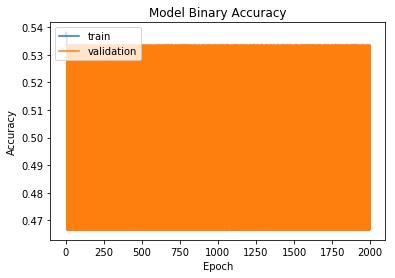

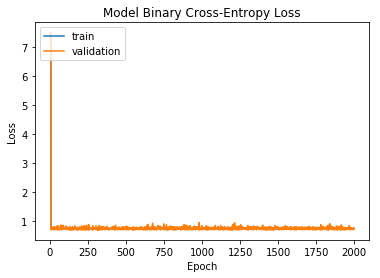

In [6]:
def display_history(history):
    # summarize history for accuracy
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model Binary Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Binary Cross-Entropy Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
display_history(transfer_history)

We can further improve our results by finetuning the model. Using the transfer learning model that we have already trained, we can 'unfreeze' a few of the layers from the base model. This will allow them to be trained, giving us an even better fit on the data. 

In [8]:
top_layer = build_fully_connected_top_layer(base_model.output_shape[1:])
top_layer.load_weights(top_layers_weights_path)
convx_model = Model(inputs=base_model.input, outputs=top_layer(base_model.output))

for layer in convx_model.layers[:len(convx_model.layers) - fine_tuning_layers_to_train]:
    layer.trainable = False

convx_model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=0.005),
                    metrics=[metrics.binary_accuracy])

data_generator = ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = data_generator.flow_from_directory(
    VAL_PATH,
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='binary')

fine_tune_history = convx_model.fit_generator(
    train_generator,
    steps_per_epoch=num_training_steps,
    epochs=fine_tuning_epochs,
    validation_data=validation_generator,
    validation_steps=num_validation_steps,
    shuffle=True,
    verbose=1
)

with open(os.path.join(models_save_directory, "best_model.json".format(model_name)), "w") as json_file:
    json_file.write(convx_model.to_json())

Found 80725 images belonging to 2 classes.
Found 8970 images belonging to 2 classes.
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[1000,256,256,64]
	 [[Node: conv1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_1_0/_1891, conv1/kernel/read)]]
	 [[Node: loss_2/mul/_2147 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_6297_loss_2/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv1/convolution', defined at:
  File "C:\Users\merke\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\merke\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\merke\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\merke\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\merke\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\merke\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\merke\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\merke\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\merke\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\merke\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\merke\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\merke\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\merke\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\merke\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\merke\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\merke\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\merke\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\merke\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\merke\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\merke\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-94833a877e0d>", line 17, in <module>
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(512, 512, 3))
  File "C:\Users\merke\Anaconda3\lib\site-packages\keras\applications\resnet50.py", line 207, in ResNet50
    64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
  File "C:\Users\merke\Anaconda3\lib\site-packages\keras\engine\topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\merke\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "C:\Users\merke\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3164, in conv2d
    data_format='NHWC')
  File "C:\Users\merke\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 661, in convolution
    op=op)
  File "C:\Users\merke\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 331, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "C:\Users\merke\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 653, in op
    name=name)
  File "C:\Users\merke\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "C:\Users\merke\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 403, in conv2d
    data_format=data_format, name=name)
  File "C:\Users\merke\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\merke\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\merke\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1000,256,256,64]
	 [[Node: conv1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_1_0/_1891, conv1/kernel/read)]]
	 [[Node: loss_2/mul/_2147 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_6297_loss_2/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


Once again, we will plot the history of our training.

In [ ]:
display_history(fine_tune_history)

Our model has now been fine tuned and the training process is complete! Lets evaluate the results. While we are also going to look at accuracy, our primary metric of evaluation is going to be f-beta, with a beta score of three. With this, we will get to see which models fit the data well while giving more weight to good recall. 

And now, the evaluation.

In [ ]:
with open(os.path.join(models_save_directory, "best_model.json"), 'r') as model_file:
    convx_model = model_from_json(model_file.read())
    
convx_model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=0.005),
                    metrics=[metrics.binary_accuracy])

healthy_test_images = count_files(os.path.join(TEST_PATH, "healthy"))
unhealthy_test_images = count_files(os.path.join(TEST_PATH, "unhealthy"))
test_iteration_count = get_iterations_per_epoch((healthy_test_images + unhealthy_test_images), batch_size)
test_labels = np.array(([0] * healthy_test_images) + ([1] * unhealthy_test_images))

data_generator = ImageDataGenerator(rescale=1. / 255)

test_generator = data_generator.flow_from_directory(
    TEST_PATH,
    target_size=target_image_size,
    batch_size=batch_size,
    class_mode='binary'
)

raw_predictions = convx_model.predict_generator(test_generator, test_iteration_count)
predictions = np.round(raw_predictions)
accuracy = accuracy_score(test_labels, predictions)
f3_score = fbeta_score(test_labels, predictions, 3)
conf_matrix = confusion_matrix(test_labels, predictions)
random_sample = [
    raw_predictions[0], 
    raw_predictions[1000], 
    raw_predictions[2000], 
    raw_predictions[3000], 
    raw_predictions[4000], 
    raw_predictions[5000], 
    raw_predictions[10000], 
    raw_predictions[12000], 
    raw_predictions[15000], 
    raw_predictions[18000], 
    raw_predictions[20000]
]
print("Random Sample: {}".format(random_sample))
print("Accuracy: {}".format(accuracy))
print("F3 Score: {}".format(f3_score))
print("Confusion Matrix: \n{}".format(conf_matrix))